# Constants

## Only if needed
```
import os

# Login with tenant ID
os.system("az login --tenant 3ad0b905-34ab-4116-93d9-c1dcc2d35af6 --output none")

# Set the subscription programmatically
os.system("az account set --subscription eca2eddb-0f0c-4351-a634-52751499eeea")
```

In [1]:
import os, json
from IPython.display import Markdown, display
from dotenv import load_dotenv # requires python-dotenv
from PIL import Image # requires pip install pillow
from datetime import datetime
from common.agents_helper_functions_NEW import *
import importlib.metadata
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

if not load_dotenv("./../config/credentials_my.env"):
    print("Environment variables not loaded, cell execution stopped")
else:
    print("Environment variables have been loaded ;-)")


project_endpoint = os.environ["AZURE_AIF_PROJECT_ENDPOINT"]
deployment_name =  os.environ["MODEL_DEPLOYMENT_NAME"]
api_version = os.environ["OPENAI_API_VERSION"] # at least "2025-03-01-preview"

print(f'Project Endpoint: <{project_endpoint}>')
print(f"azure-ai-projects library installed version: {importlib.metadata.version("azure-ai-projects")}")
print(f"azure-ai-agents library installed version: {importlib.metadata.version("azure-ai-agents")}")

Environment variables have been loaded ;-)
Project Endpoint: <https://aif01svcsbu6z.services.ai.azure.com/api/projects/aif01basicprj01>
azure-ai-projects library installed version: 1.0.0b12
azure-ai-agents library installed version: 1.1.0b3


# Create AI Foundry Project Client

In [2]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

project_client = AIProjectClient(
    endpoint=project_endpoint,
    credential=DefaultAzureCredential(),
)

project_client

# Extract Azure OpenAI client from the AI Foundry Project

In [3]:
from openai import AzureOpenAI # <<<<< NOT NEEDED FOR AZURE AI FOUNDRY SDK

# using explicit type hinting for IntelliSense
azure_openai_client: AzureOpenAI = project_client.inference.get_azure_openai_client(
    api_version = api_version,
)

# if NOT MI --> azure_openai_client.api_key = os.environ.get("AZURE_OPENAI_API_KEY") 

print(azure_openai_client.base_url)

https://aif01svcsbu6z.services.ai.azure.com/openai/


In [4]:
# use the client with Responses API's

response = azure_openai_client.responses.create(
    model = deployment_name,
    input = "Tell me what Microsoft Azure is in less than 10 words")

print(f"Response from {type(azure_openai_client)} object: {response.output_text}")

Response from <class 'openai.lib.azure.AzureOpenAI'> object: Microsoft Azure: Cloud platform for building, deploying, managing applications.


# Create an OpenAI **Assistant** with CodeInterpreterTool, 
# from an Azure OpenAI Client extracted from the AI Foundry Project

In [5]:
# First, create the code interpreter definitions...
code_interpreter_tool = {"type": "code_interpreter"}
code_interpreter_resources={"code_interpreter":{"file_ids":[]}}

# ...then, create the OpenAI Assistant Agent, attaching code interpreter
assistant = azure_openai_client.beta.assistants.create(
    name = "OpenAI Assistant #1",  
    model=deployment_name,
    instructions="You are a helpful agent",
    tools=[code_interpreter_tool],
    tool_resources=code_interpreter_resources,
    temperature=1,
    top_p=1
)

print(f"Assistant {assistant.name} ({assistant.id}) has been created. It's available in the AI Foundry Assistants playground.")

Assistant OpenAI Assistant #1 (asst_1J0nt6AtXGZBex8vSDg2iciy) has been created. It's available in the AI Foundry Assistants playground.


# Create the thread and attach a new message to it

In [6]:
# Create a thread
thread = azure_openai_client.beta.threads.create()

print(f"The following thread has been created:\n{thread}\n")

# Add a user message to the thread
message = azure_openai_client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="""
Please create a bar chart for the operating profit using 
the following data and provide the file to me:
Company A: $1.2 million, Company B: $2.5 million,
Company C: $3.0 million, Company D: $1.8 million
""",
)
print(f"The following message has been attached to thread <{thread.id}>:\n{message}")

# to retrieve the message of a thread, please run: azure_openai_client.beta.threads.messages.retrieve (thread_id=thread.id, message_id=message.id)

The following thread has been created:
Thread(id='thread_dcYses0VU2AZAr5ax4efMNHl', created_at=1751794553, metadata={}, object='thread', tool_resources=ToolResources(code_interpreter=None, file_search=None))



C:\Users\mauromi\AppData\Local\Temp\ipykernel_26112\2121601295.py:2: DeprecationWarning: The Assistants API is deprecated in favor of the Responses API
  thread = azure_openai_client.beta.threads.create()
C:\Users\mauromi\AppData\Local\Temp\ipykernel_26112\2121601295.py:7: DeprecationWarning: The Assistants API is deprecated in favor of the Responses API
  message = azure_openai_client.beta.threads.messages.create(


The following message has been attached to thread <thread_dcYses0VU2AZAr5ax4efMNHl>:
Message(id='msg_tthatXL5U2iTievTcVDiL7ff', assistant_id=None, attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], value='\nPlease create a bar chart for the operating profit using \nthe following data and provide the file to me:\nCompany A: $1.2 million, Company B: $2.5 million,\nCompany C: $3.0 million, Company D: $1.8 million\n'), type='text')], created_at=1751794553, incomplete_at=None, incomplete_details=None, metadata={}, object='thread.message', role='user', run_id=None, status=None, thread_id='thread_dcYses0VU2AZAr5ax4efMNHl')


# Run the agent syncrhonously

In [7]:
%%time

# Run the agent
run = azure_openai_client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)
print(f"Run status: {run.status}")

# Looping until the run completes or fails
import time
while run.status in ['queued', 'in_progress', 'cancelling']:
    time.sleep(1)
    run = azure_openai_client.beta.threads.runs.retrieve\
        (thread_id=thread.id, run_id=run.id)
    print(f"Run status: {run.status}")  

<timed exec>:2: DeprecationWarning: The Assistants API is deprecated in favor of the Responses API


Run status: queued


<timed exec>:12: DeprecationWarning: The Assistants API is deprecated in favor of the Responses API


Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: completed
CPU times: total: 46.9 ms
Wall time: 8.98 s


# Retrieve messages from the thread after the agent run execution

In [8]:
import openai

if run.status == 'completed':
    messages = azure_openai_client.beta.threads.messages.list(thread_id=thread.id)
    messages_nr = len(messages.data)
    print(f"Here are the {messages_nr} messages:\n")
    
    for i, message in enumerate(reversed(messages.data), 1):
        j =0
        print(f"\n===== MESSAGE {i} =====")
        for c in message.content:
            j += 1
            if (type(c) is openai.types.beta.threads.image_file_content_block.ImageFileContentBlock):
                print(f"\nCONTENT {j} (ImageFileContentBlock)--> image_file id: {c.image_file.file_id}")
            elif (type(c) is openai.types.beta.threads.text_content_block.TextContentBlock):
                print(f"\nCONTENT {j} (TextContentBlock) --> Text: {c.text.value}")
                for a in c.text.annotations:
                    print(f">>> Annotation in MessageTextContent {j} of message {i}: {a.text}\n")
else:
    print(f"Sorry, I can't proceed because the run status is {run.status}")

Here are the 2 messages:


===== MESSAGE 1 =====

CONTENT 1 (TextContentBlock) --> Text: 
Please create a bar chart for the operating profit using 
the following data and provide the file to me:
Company A: $1.2 million, Company B: $2.5 million,
Company C: $3.0 million, Company D: $1.8 million


===== MESSAGE 2 =====

CONTENT 1 (TextContentBlock) --> Text: The bar chart for the operating profits has been created and saved. You can download the file using the link below:

[Download the chart](sandbox:/mnt/data/operating_profit_chart.png)
>>> Annotation in MessageTextContent 1 of message 2: sandbox:/mnt/data/operating_profit_chart.png



C:\Users\mauromi\AppData\Local\Temp\ipykernel_26112\3126846534.py:4: DeprecationWarning: The Assistants API is deprecated in favor of the Responses API
  messages = azure_openai_client.beta.threads.messages.list(thread_id=thread.id)


# Retrieve and download eventual images
**Note**: sometimes, the image link is provided in the textual answer. In this case it won't be automatically shown

text: The bar chart for the operating profits has been created and saved. You can download the file using the link below:

[Download the chart](sandbox:/mnt/data/operating_profit_chart.png)
File downloaded as assistant-H9CoPWG3nfKHpin4ghRTGG.jpg
image_file: assistant-H9CoPWG3nfKHpin4ghRTGG


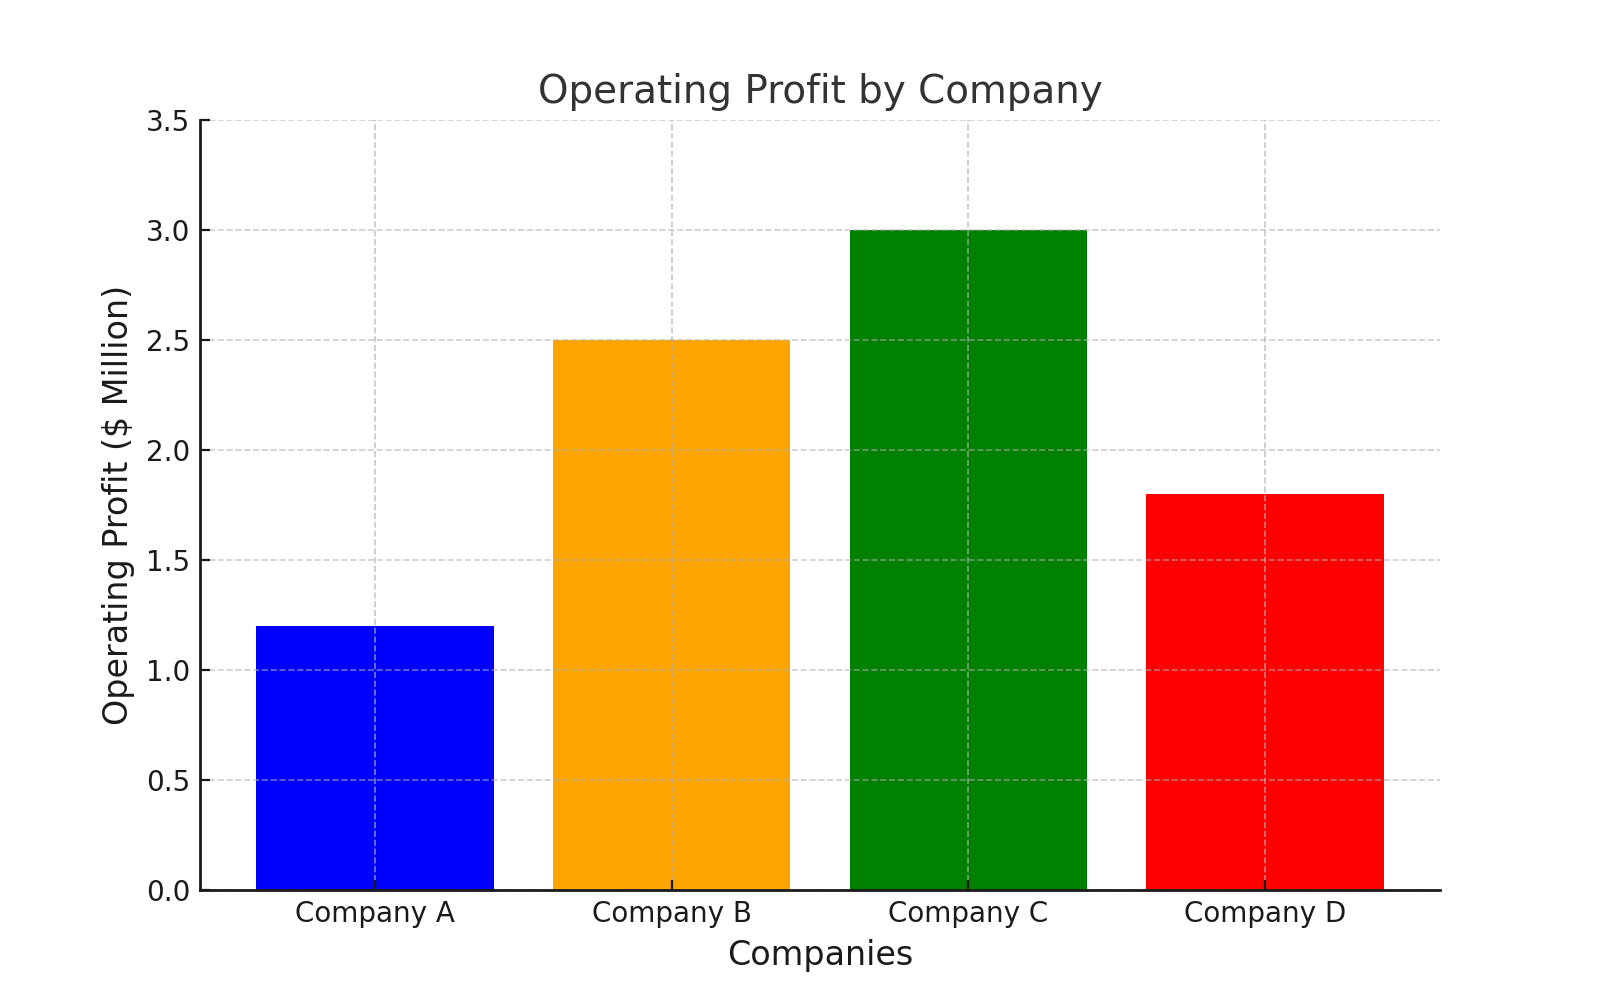

In [9]:
from IPython.display import Image, display
for c in json.loads(messages.to_json())["data"][0]["content"]:
    if c["type"]=="text":
        print(f'text: {c["text"]["value"]}')
        for a in c["text"]["annotations"]:
            file_id = a["file_path"]["file_id"]
            content = azure_openai_client.files.content(file_id=file_id)
            image= content.write_to_file(f"{file_id}.jpg")
            print(f"File downloaded as {file_id}.jpg")
            print(f'image_file: {file_id}')
            display(Image(filename=f"{file_id}.jpg"))          
    elif c["type"]=="image_file":
        file_id = c["image_file"]["file_id"]
        content = azure_openai_client.files.content(file_id=file_id)
        image= content.write_to_file(f"{file_id}.jpg")
        print(f"File downloaded as {file_id}.jpg")
        print(f'image_file: {file_id}')
        display(Image(filename=f"{file_id}.jpg"))

# Teardown

In [10]:
# delete files stored with this assistant 

for file in azure_openai_client.files.list().data:
    print(azure_openai_client.files.delete(file_id=file.id))

FileDeleted(id='assistant-H9CoPWG3nfKHpin4ghRTGG', deleted=True, object='file')


In [11]:
# delete thread. Beaware: it's not possible to retrieve the threads list as it is with AI Foundry Agents!
azure_openai_client.beta.threads.delete(thread_id=thread.id)

C:\Users\mauromi\AppData\Local\Temp\ipykernel_26112\3176731398.py:2: DeprecationWarning: The Assistants API is deprecated in favor of the Responses API
  azure_openai_client.beta.threads.delete(thread_id=thread.id)


ThreadDeleted(id='thread_dcYses0VU2AZAr5ax4efMNHl', deleted=True, object='thread.deleted')

In [12]:
def list_assistants(aoc: AzureOpenAI, delete:bool=False):
    assistants = aoc.beta.assistants.list(limit=100).data

    i=0
    while len(assistants) > 0:
        for assistant in assistants:
            i=i+1
            if delete:
                print(f"Deleting assistant {i}: {assistant.id} ({assistant.name}) created at {datetime.fromtimestamp(assistant.created_at).strftime('%Y-%m-%d %H:%M:%S')}...")
                # client.beta.assistants.delete(assistant.id)
                aoc.beta.assistants.delete(assistant.id)
            else:
                print(f"Assistant {i}: {assistant.id} ({assistant.name}) created at {datetime.fromtimestamp(agent['created_at']).strftime('%Y-%m-%d %H:%M:%S')}...")

            assistants.remove(assistant)
            #agents = aoc.agents.list_agents(limit=100)['data']
    
    print (f"\n{i} assistants have been successfully processed.")


list_assistants(azure_openai_client, delete=True)

Deleting assistant 1: asst_1J0nt6AtXGZBex8vSDg2iciy (OpenAI Assistant #1) created at 2025-07-06 11:35:53...
Deleting assistant 2: asst_q8Zy1qosDNMaAStwZcUBdbni (OpenAI Assistant #1) created at 2025-07-06 11:30:57...
Deleting assistant 3: asst_ji5DmwizM1UPg6ylgBwkSpK3 (OpenAI Assistant #1) created at 2025-07-06 11:28:15...
Deleting assistant 4: asst_085vLzCwPHoYFr2tgTuh0og7 (OpenAI Assistant #1) created at 2025-07-06 11:25:42...
Deleting assistant 5: asst_j47fGt8892OpMnXY7PhBYajn (OpenAI Assistant #1) created at 2025-07-06 11:33:43...
Deleting assistant 6: asst_k1a9UqRk4lnmXCHSvU0x5NPo (OpenAI Assistant #1) created at 2025-07-06 11:26:25...
Deleting assistant 7: asst_mis8WTMc2dXP48hjvN8iCNyG (OpenAI Assistant #1) created at 2025-07-06 11:29:41...

7 assistants have been successfully processed.


# HIC SUNT LEONES